## Project goal: build a CV algorithm to solve Sudoku.

based on https://medium.com/@neshpatel/solving-sudoku-part-ii-9a7019d196a2

In [8]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from skimage import io
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import rescale
import cv2
from skimage.transform import ProjectiveTransform, warp
from skimage.feature import match_template
from tqdm import tqdm_notebook
from PIL import Image
from skimage import util
import warnings
warnings.filterwarnings("ignore")

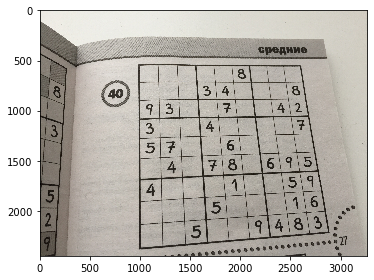

In [9]:
image_name = "IMG_1263.JPG"
io.imshow(image_name)
plt.show()

# Part 1. Normalize the image

In [10]:
def distance(p1, p2):
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))


def normalize_image(fname):
    image_full = io.imread(fname, as_gray=True, plugin='matplotlib')
    image_scaled= rescale(image_full, 0.5)
    edges = canny(image_scaled)
    edges = (edges).astype(np.uint8)
    ext_contours = cv.findContours(edges.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[1]
 
    contour = max(ext_contours, key=cv.contourArea)
    contour = contour.squeeze()
    epsilon = 0.1 * cv.arcLength(contour, True)
    corners = cv.approxPolyDP(contour, epsilon, True).squeeze()
    src = np.array(corners, dtype='float32')
    
    src_middle_x = sum([el[0] for el in src]) / 4
    src_middle_y = sum([el[1] for el in src]) / 4
    
    for point in src:
        if (point[0] > src_middle_x) and (point[1] > src_middle_y):
            lower_right = point
        if (point[0] < src_middle_x) and (point[1] < src_middle_y):
            upper_left = point
        if (point[0] > src_middle_x) and (point[1] < src_middle_y):
            lower_left = point
        if (point[0] < src_middle_x) and (point[1] > src_middle_y):
            upper_right = point

    src = np.array([lower_left, upper_left, upper_right, lower_right], dtype='float32')
        
    
    side = max([distance(corners[3], corners[0]),
                distance(corners[1], corners[2]),
                distance(corners[3], corners[2]),
                distance(corners[1], corners[0])])
    dst = np.array([[side, 0], [0, 0], [0, side],  [side, side]], dtype='float32')
    m = cv.getPerspectiveTransform(src, dst)
    
    normalized_image = cv.warpPerspective(image_scaled, m, (int(side), int(side)))
    io.imsave('normalized_{}'.format(fname), normalized_image)
    return normalized_image

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


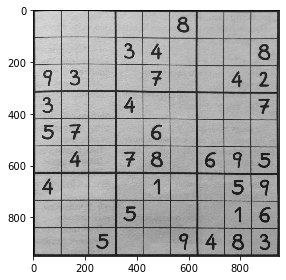

In [11]:
io.imshow(normalize_image(image_name))
plt.show()

# Part 2. Recognize digits

In [12]:
def match_value(image_1, image_2):
    result = match_template(image_1, image_2)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)
    return max(max_val, abs(min_val))


def recognize_digits(normalized_fname):
    image = io.imread(normalized_fname,0)
    
    cell_side_length = 100

    image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    image = cv.resize(image, (9 * cell_side_length, 9 * cell_side_length))
    
    recognized_digits = np.zeros([9,9])
    for i in tqdm_notebook(range(9)):
        for j in range(9):
            cell_image = image[i * cell_side_length : (i + 1) * cell_side_length,
                               j * cell_side_length : (j + 1) * cell_side_length]
            
            cell_image = util.invert(cell_image)
            kernel = np.ones((3,3), np.uint8) 
            cell_image = cv2.erode(cell_image, kernel, iterations=1)

#             if i == 0 and j == 2:
#                 io.imshow(cell_image)

            max_match_value = -100
            pack_num = 3
            while pack_num > 0:
                for digit in range(1, 10):
                    template = cv.imread('./pack_{}/{}_{}.jpeg'.format(pack_num, digit, pack_num),
                                         cv.IMREAD_GRAYSCALE)
                    template = cv.resize(template, (90, 90))
                    
                    match = match_value(cell_image, template)
                    if match > max_match_value:
                        best_digit = digit
                        max_match_value = match
                pack_num -= 1
            if max_match_value >= 0.4:
                recognized_digits[i][j] = best_digit
            else:
                recognized_digits[i][j] = 0
    return recognized_digits.astype(int)

In [13]:
sudoku_matrix = recognize_digits('normalized_{}'.format(image_name))
print(sudoku_matrix)


[[0 0 0 0 0 8 0 0 0]
 [0 0 0 3 4 0 0 0 8]
 [9 3 0 0 7 0 0 4 2]
 [3 0 0 4 0 0 0 0 7]
 [5 7 0 0 6 0 0 0 0]
 [0 4 0 7 8 0 6 9 5]
 [4 0 0 0 1 0 0 5 9]
 [0 0 0 5 0 0 0 1 6]
 [0 0 5 0 0 9 4 8 3]]


# Part 3. Solve sudoku

In [14]:
from sudoku import solve_sudoku

In [15]:
solution = solve_sudoku(sudoku_matrix)
print(solution)

[[6 2 4 9 5 8 3 7 1]
 [1 5 7 3 4 2 9 6 8]
 [9 3 8 1 7 6 5 4 2]
 [3 8 6 4 9 5 1 2 7]
 [5 7 9 2 6 1 8 3 4]
 [2 4 1 7 8 3 6 9 5]
 [4 6 3 8 1 7 2 5 9]
 [8 9 2 5 3 4 7 1 6]
 [7 1 5 6 2 9 4 8 3]]


In [17]:
def display_result(normalized_fname, sudoku_matrix, solution):
    image = Image.open(normalized_fname, 'r')
    image = image.resize((900,900))
    
    for i in range(9):
        for j in range(9):
            if sudoku_matrix[i][j] == 0:
                digit = Image.open('./pack_1/{}_1.jpeg'.format(solution[i][j]))
                digit = digit.resize((100,100))
                image.paste(digit, (100 * j, 100 * i))
    image.save('solved_{}'.format(image_name))
    display(image)

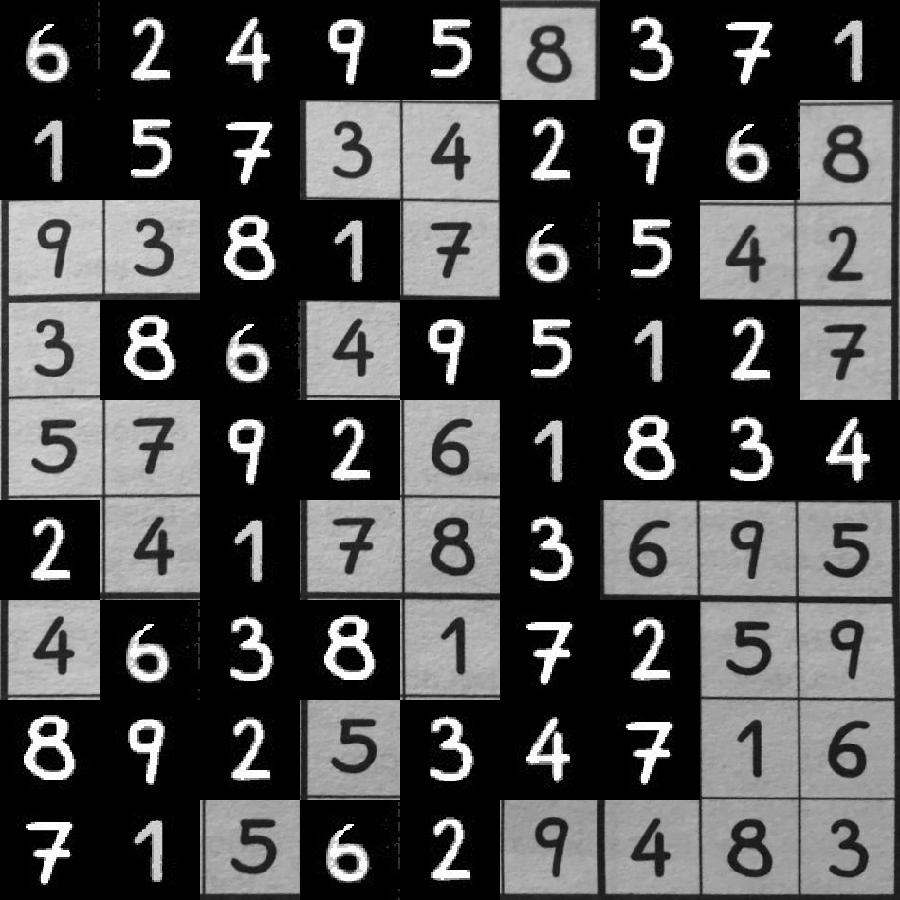

In [18]:
display_result('normalized_{}'.format(image_name), sudoku_matrix, solution)